In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline


### load data

In [2]:
# demand factor

file = open('../../preprocessing/s_demand.pkl', 'rb')

s_demand = pickle.load(file)

file.close()

s_demand.describe()

count    87672.000000
mean         0.672161
std          0.092507
min          0.423928
25%          0.601167
50%          0.677592
75%          0.741519
max          1.000000
Name: NEM, dtype: float64

In [3]:
# VRE capacity factor 

file1 = open('../../preprocessing/df_VRE.pkl', 'rb')

df_VRE = pickle.load(file1)

file1.close()

df_VRE.describe()

,NSA_wind,ADE_wind,SESA_wind,NQ_wind,CQ_wind,SWQ_wind,SEQ_wind,NNS_wind,NCEN_wind,SWNSW_wind,...,SEQ_pv,NNS_pv,NCEN_pv,SWNSW_pv,CAN_pv,CVIC_pv,NVIC_pv,MEL_pv,LV_pv,TAS_pv
count,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,...,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000
mean,0.487176,0.518950,0.482749,0.412358,0.399124,0.371925,0.298820,0.369941,0.410580,0.430320,...,0.223738,0.230826,0.224122,0.227533,0.221578,0.220851,0.213939,0.200579,0.191443,0.184123
std,0.250937,0.311564,0.294525,0.186893,0.209994,0.216614,0.232979,0.229998,0.264962,0.256515,...,0.292910,0.300694,0.294765,0.299780,0.302242,0.298624,0.293695,0.280950,0.271458,0.273811
min,0.000170,0.000000,0.000000,0.003431,0.000033,0.000023,0.000000,0.000073,0.000015,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.283203,0.239799,0.226274,0.268482,0.233753,0.195482,0.115597,0.175866,0.176217,0.215271,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.487286,0.532403,0.470042,0.412669,0.403292,0.361328,0.243690,0.352348,0.392946,0.422647,...,0.003167,0.004674,0.003822,0.004537,0.001356,0.001878,0.001367,0.001156,0.000933,0.000000
75%,0.689897,0.805126,0.736311,0.553285,0.558590,0.530006,0.435457,0.540617,0.625332,0.633184,...,0.476179,0.497844,0.476866,0.475440,0.440186,0.460181,0.428022,0.382439,0.353978,0.318978
max,0.990404,0.991690,0.991685,0.966683,0.980837,0.986573,0.991660,0.991663,0.991540,0.991620,...,0.921856,0.952050,0.945950,0.952181,0.986578,0.948800,0.957956,0.967111,0.982356,1.000000


In [4]:
# bootstrap selections
file2 = open('M_bootstrap.pkl', 'rb')

M_bootstrap = pickle.load(file2)

file2.close()

M_bootstrap.shape

(100, 17520)

In [5]:
df_cost=pd.read_csv('../../raw_data/gencost_2223_summary.csv', skiprows=1, index_col=0)
df_cost

,CAP [AUD/kW],fixed O&M [AUD/kW/yr],variable O&M [AUD/MWh],CO2 store [AUD/MWh],fuel [AUD/MWh]
technology,,,,,
onshore,1642,25.00,0.0,0.0,0.000000
solar,498,17.00,0.0,0.0,0.000000
gasCCS,3012,16.35,7.2,1.9,106.568182


In [6]:
# capacity cost per MW per year, assuming 25 years economic life

cap_wind=df_cost.iloc[0,0]*1000/25 #[AUD/MW/yr]
cap_pv=df_cost.iloc[1,0]*1000/25 #[AUD/MW/yr]
cap_gas=df_cost.iloc[2,0]*1000/25 #[AUD/MW/yr]

fOM_wind=df_cost.iloc[0,1]*1000 #[AUD/MW/yr] 
fOM_pv=df_cost.iloc[1,1]*1000 #[AUD/MW/yr] 
fOM_gas=df_cost.iloc[2,1]*1000 #[AUD/MW/yr] 



# energy cost per MWh
gvar=df_cost.iloc[2, [2,3,4]].sum() # total variable cost of gas with CCS [AUD/MWh]

# check
print('CAP wind', cap_wind)
print('O&M wind', fOM_wind)
print('CAP pv', cap_pv)
print('O&M pv', fOM_pv)
print('CAP gas', cap_gas)
print('O&M gas', fOM_gas)
print('var cost of gas', gvar)


CAP wind 65680.0
O&M wind 25000.0
CAP pv 19920.0
O&M pv 17000.0
CAP gas 120480.0
O&M gas 16350.000000000002
var cost of gas 115.66818181818199


### determine cost values on the efficient frontier

In [7]:
np.concatenate([np.arange(24, 28, 0.5)*10000, np.arange(28, 32)*10000, 
                                    np.arange(32, 40,2)*10000, np.arange(40, 64,4)*10000])

array([240000., 245000., 250000., 255000., 260000., 265000., 270000.,
       275000., 280000., 290000., 300000., 310000., 320000., 340000.,
       360000., 380000., 400000., 440000., 480000., 520000., 560000.,
       600000.])

In [8]:
# function to determine the sampling points on the EF for each bootstrap run

LC_constraints_core=np.concatenate([np.arange(24, 28, 0.5)*10000, np.arange(28, 32)*10000, 
                                    np.arange(32, 40,2)*10000, np.arange(40, 64,4)*10000])
def EF_cost_constraints(cost_mincost, cost_minrisk):
    
    # pick out the core points within range
    LC_constraints=LC_constraints_core[np.where((LC_constraints_core>=cost_mincost) & 
                                            (LC_constraints_core<=cost_minrisk))]
    
    # determine where to insert extra sampling points at the beginning
    LC_diff_start=LC_constraints[0]-cost_mincost
    
    if LC_diff_start>2500:
        addC1=LC_constraints[0]-2000
        LC_constraints=np.insert(LC_constraints, 0, addC1)
        addC2=(addC1+cost_mincost)/2
        LC_constraints=np.insert(LC_constraints, 0, addC2)
    elif (LC_diff_start<2500) and (LC_diff_start>1250):
        addC1=(LC_constraints[0]+cost_mincost)/2
        LC_constraints=np.insert(LC_constraints, 0, addC1)
        addC2=(LC_constraints[1]+LC_constraints[2])/2
        LC_constraints=np.insert(LC_constraints, 2, addC2)

    else:
        addC1=(LC_constraints[0]+LC_constraints[1])/2
        LC_constraints=np.insert(LC_constraints, 1, addC1)
        addC2=(LC_constraints[0]+addC1)/2
        LC_constraints=np.insert(LC_constraints, 1, addC2)
        
    if (LC_constraints[0]-cost_mincost)>250:
        addC=(cost_mincost+LC_constraints[0])/2
        LC_constraints=np.insert(LC_constraints, 0, addC)
   
    
    

        
    
    return LC_constraints
    
    

In [10]:
EF_cost_constraints(273246.7484429451, 518028.48630780366)

array([273685.06133221, 274123.37422147, 275000.        , 277500.        ,
       280000.        , 290000.        , 300000.        , 310000.        ,
       320000.        , 340000.        , 360000.        , 380000.        ,
       400000.        , 440000.        , 480000.        ])

## main loop

In [11]:
# VRE only has fixed costs = capital + O&M
v_VREfixed=np.concatenate([np.repeat((cap_wind + fOM_wind),16) , np.repeat((cap_pv + fOM_pv),16)])
# add gas fixed cost
v_allfixed=np.append(v_VREfixed, cap_gas + fOM_gas)

# each bootstrap sample is equivalent to 2 years of data
N_years=2

# number of rows in each bootstrap sample = number of time steps considered
T=M_bootstrap.shape[1]

In [12]:
from scipy.optimize import linprog

from qpsolvers import Problem, solve_problem
from scipy import sparse
from scipy.linalg import block_diag


EF=dict()

for bs in range(100):
#for bs in range(3): # test
    
    print(bs)
    
    
    idx_selection=M_bootstrap[bs]
    
    
    _s_demand=s_demand.iloc[idx_selection].values
    _df_VRE=df_VRE.iloc[idx_selection]

    M_p=_df_VRE.values
    
    P_cov=_df_VRE.cov().values

    Pd_cov=np.array([np.cov(_s_demand, _df_VRE[col])[0,1] for col in _df_VRE.columns])
       
    # initialise output
    df_EF=pd.DataFrame(index=df_VRE.columns.to_list()+['gas'])
    
    ###############
    # LP min cost potfolio
    ###############
    
    # linear cost objective
    
    c=np.concatenate([v_allfixed , np.repeat(gvar/N_years, T)]) # v_x =[X_i, X_g, g_t]
    
    # equality constraint: there is none

    #inequality constraints
    ## no demand deficit
    Aub_demand=np.hstack([-M_p, np.zeros((T,1)), -np.identity(T)])
    bub_demand=-(_s_demand)
    ## capacity of gas
    Aub_gas=np.hstack([np.zeros((T,32)), -np.ones((T,1)),  np.identity(T)])
    bub_gas=np.zeros(T)
    ## VRE IC
    Aub_IC=np.concatenate([np.repeat(-1, 32), np.repeat(0, T+1)]).reshape(1,-1)
    bub_IC=-1

    Aub=np.vstack([Aub_demand, Aub_gas, Aub_IC])

    bub=np.append(np.append(bub_demand, bub_gas), bub_IC)

    lb=np.repeat(0, len(c))
    ub=np.concatenate([np.repeat(100, 32), np.repeat(1, T+1)])
    
    boundslp=[(lb[i], ub[i]) for i in range(len(lb))]
    
    # solve model    
    m_mincost = linprog(c, A_ub=Aub, b_ub=bub, bounds=boundslp, method= 'highs-ipm')
    if m_mincost.status!=0:
        print(bs, 'mincost is not optimal.')
    
    # output resulting portfolio
    portfolio_mincost=m_mincost.x[:33]
    VRE_portfolio_mincost=m_mincost.x[:32]
    df_EF[1]=portfolio_mincost
    
    # value of the cost objective
    cost_mincost=m_mincost.fun
    
    # compute the risk (sigma square)
    s_residual_mincost=_s_demand-M_p@VRE_portfolio_mincost
    risk_mincost=np.var(s_residual_mincost)
    
    print(cost_mincost)

    
    #################
    # min risk portfolio
    #################
        
    problem_minrisk = Problem(P=P_cov, q=-Pd_cov, G=-np.repeat(1,32), h=np.array([-1]),  A=None, 
                          lb=np.zeros(32), ub=np.repeat(100, 32))                  
    m_minrisk = solve_problem(problem_minrisk, solver='quadprog', verbose=True)
    if m_minrisk.found is not True:
        print(bs, 'minrisk is not optimal.')
    
    portfolio_minrisk=m_minrisk.x
    risk_minrisk=m_minrisk.obj*2 # multiply by 2 to get variance  
    
    # compute portfolio cost
    
    v_rplus_minrisk=_s_demand-M_p@portfolio_minrisk
    v_rplus_minrisk[np.where(v_rplus_minrisk<0)]=0
    
    cost_minrisk=v_VREfixed@portfolio_minrisk+ (cap_gas + fOM_gas)*v_rplus_minrisk.max() +\
                v_rplus_minrisk.sum()*gvar/N_years
    print(cost_minrisk)

    
    ################
    # samples along the EF
    ################
    
    ###
    # set up objectives and constraints, except specifying the values of the cost constraints
    ###
   
    # quadratic objective
    P=sparse.csr_matrix(block_diag(P_cov, np.zeros([T+1,T+1])))
    q=np.concatenate([-Pd_cov, np.zeros(T+1)])


    # equality constraints

    ## set the cost value, only LHS here
    
    ## fixed cost to sample along the EF
    AeqfixC=c.reshape(1,-1) # reshape to (1, 32+N)
    A=sparse.csr_matrix(AeqfixC)
    
    
    # inequality constraints 
    # same as LP above but change to sparse.csc_matrix to improve efficiency
    G=sparse.csc_matrix(Aub)
    # h=bub, same as before
    
    # bounds on the decision variables are already defined in the LP above (lb and ub)
    
    ####
    # loop through cost constraints
    ####
    
    # determine the sampling points
    C_constraints = EF_cost_constraints(cost_mincost, cost_minrisk)
    #C_constraints = EF_cost_constraints(cost_mincost, cost_minrisk)[3:5] # for testing
    
    # record the risk objective values (sigma square)
    v_risk=np.array([])
    
    #print(C_constraints)
    
    for i in range(len(C_constraints)) :
        print(C_constraints[i])
        _b=np.array([C_constraints[i]])
        _problem = Problem(P, q, G, bub, A, _b, lb, ub)
        _solution = solve_problem(_problem, solver="clarabel") #,verbose=True)
        if _solution.found is not True:
            print(bs, C_constraints[i], 'is not optimal.')
        v_risk=np.append(v_risk, _solution.obj*2)        
        df_EF[i+2]=_solution.x[:33]
        
        
    # add minrisk solution to the end of the dataframe
    df_EF[len(C_constraints)+2]=np.append(portfolio_minrisk, v_rplus_minrisk.max())
    _v_cost=np.concatenate([np.array([cost_mincost]), C_constraints, np.array([cost_minrisk])])
    _v_risk=np.concatenate([np.array([risk_mincost]), v_risk, np.array([risk_minrisk])])
    _df_obj=pd.DataFrame(index=['cost', 'sigma_sq'], columns=df_EF.columns, data=np.vstack([_v_cost, _v_risk]))
    
    EF[bs]=pd.concat([df_EF, _df_obj], axis=0)


0
268516.29383160674
516124.23195454356
268887.22037370503
269258.1469158034
270000.0
272500.0
275000.0
280000.0
290000.0
300000.0
310000.0
320000.0
340000.0
360000.0
380000.0
400000.0
440000.0
480000.0
1
264089.69014957035
517925.5331847498
264544.8450747852
265000.0
266250.0
267500.0
270000.0
275000.0
280000.0
290000.0
300000.0
310000.0
320000.0
340000.0
360000.0
380000.0
400000.0
440000.0
480000.0
2
266531.4212814346
517221.01753495133
266898.56596107595
267265.7106407173
268000.0
270000.0
275000.0
280000.0
290000.0
300000.0
310000.0
320000.0
340000.0
360000.0
380000.0
400000.0
440000.0
480000.0
3
263536.719307315
514222.7572143567
263902.5394804863
264268.35965365754
265000.0
267500.0
270000.0
275000.0
280000.0
290000.0
300000.0
310000.0
320000.0
340000.0
360000.0
380000.0
400000.0
440000.0
480000.0
4
266624.0499932431
513570.08265925996
266968.0374949323
267312.02499662153
268000.0
270000.0
275000.0
280000.0
290000.0
300000.0
310000.0
320000.0
340000.0
360000.0
380000.0
400000.0
4

263000.0
265000.0
270000.0
275000.0
280000.0
290000.0
300000.0
310000.0
320000.0
340000.0
360000.0
380000.0
400000.0
440000.0
480000.0
41
268486.8879027711
515963.39829444385
268865.16592707834
269243.44395138556
270000.0
272500.0
275000.0
280000.0
290000.0
300000.0
310000.0
320000.0
340000.0
360000.0
380000.0
400000.0
440000.0
480000.0
42
265479.9515279504
516584.05119877297
266109.96364596277
266739.9757639752
268000.0
270000.0
275000.0
280000.0
290000.0
300000.0
310000.0
320000.0
340000.0
360000.0
380000.0
400000.0
440000.0
480000.0
43
264535.8321518548
514144.13964182156
264767.91607592744
265000.0
266250.0
267500.0
270000.0
275000.0
280000.0
290000.0
300000.0
310000.0
320000.0
340000.0
360000.0
380000.0
400000.0
440000.0
480000.0
44
266633.41238543607
513886.0928592463
266975.05928907706
267316.706192718
268000.0
270000.0
275000.0
280000.0
290000.0
300000.0
310000.0
320000.0
340000.0
360000.0
380000.0
400000.0
440000.0
480000.0
45
273226.8946624183
513310.2275526312
273670.1709968

273595.49731297465
274063.66487531643
275000.0
277500.0
280000.0
290000.0
300000.0
310000.0
320000.0
340000.0
360000.0
380000.0
400000.0
440000.0
480000.0
82
263462.61175818817
515026.2488747481
263846.95881864114
264231.30587909406
265000.0
267500.0
270000.0
275000.0
280000.0
290000.0
300000.0
310000.0
320000.0
340000.0
360000.0
380000.0
400000.0
440000.0
480000.0
83
268624.5091900769
518186.636106187
268968.3818925577
269312.2545950385
270000.0
272500.0
275000.0
280000.0
290000.0
300000.0
310000.0
320000.0
340000.0
360000.0
380000.0
400000.0
440000.0
480000.0
84
263803.6148446458
514900.4550610818
264401.8074223229
265000.0
266250.0
267500.0
270000.0
275000.0
280000.0
290000.0
300000.0
310000.0
320000.0
340000.0
360000.0
380000.0
400000.0
440000.0
480000.0
85
268533.9233028282
517687.53540189983
268900.44247712113
269266.9616514141
270000.0
272500.0
275000.0
280000.0
290000.0
300000.0
310000.0
320000.0
340000.0
360000.0
380000.0
400000.0
440000.0
480000.0
86
273315.18375080056
517367

In [13]:
# pickle
import pickle

file = open('result_bootstrap.pkl', 'wb')

# dump information to that file
pickle.dump(EF, file)

# close the file
file.close()

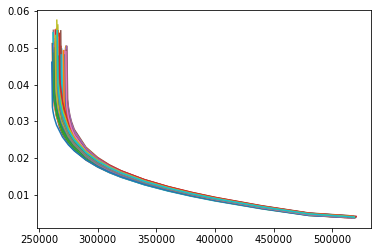

In [14]:
for bs in range(100):

    plt.plot(EF[bs].iloc[-2], EF[bs].iloc[-1])
plt.show()

In [15]:
EF[29]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
NSA_wind,0.314727,3.215306e-01,3.193499e-01,3.116173e-01,2.995123e-01,2.758405e-01,2.620840e-01,2.467624e-01,2.345619e-01,2.245873e-01,2.154307e-01,1.989796e-01,1.851897e-01,1.724749e-01,1.609549e-01,1.392711e-01,1.186048e-01,8.270686e-02
ADE_wind,0.029657,2.105046e-02,2.105700e-02,1.663389e-02,5.531874e-03,3.619795e-10,2.402306e-10,2.489815e-10,9.648313e-11,7.351914e-11,2.592511e-12,3.165009e-11,3.345619e-12,3.029034e-10,2.165812e-10,2.245400e-10,4.240377e-10,3.275446e-18
SESA_wind,0.020574,3.597264e-03,1.337054e-09,2.560684e-12,3.237694e-11,8.680625e-12,1.773767e-11,4.953419e-11,2.160149e-11,2.909343e-11,1.031697e-12,1.325831e-11,1.640546e-12,1.477653e-10,1.006619e-10,9.157223e-11,1.885673e-10,0.000000e+00
NQ_wind,0.725742,6.945499e-01,6.754099e-01,6.567441e-01,6.344019e-01,6.035082e-01,5.779923e-01,5.335213e-01,5.043492e-01,4.809720e-01,4.606761e-01,4.299425e-01,4.039463e-01,3.803835e-01,3.586920e-01,3.190809e-01,2.817665e-01,2.534564e-01
CQ_wind,0.000000,4.036031e-12,6.866614e-12,3.808727e-13,3.044481e-11,5.732248e-11,7.458502e-03,1.864491e-02,2.089070e-02,2.327560e-02,2.808384e-02,3.118775e-02,3.218410e-02,3.392601e-02,3.446926e-02,3.384738e-02,3.219337e-02,2.672089e-02
SWQ_wind,0.109332,1.592626e-01,1.826137e-01,2.026593e-01,2.023677e-01,2.042858e-01,2.012443e-01,2.055734e-01,2.072395e-01,2.039972e-01,1.968991e-01,1.863582e-01,1.784088e-01,1.702366e-01,1.625132e-01,1.484571e-01,1.353315e-01,1.413136e-01
SEQ_wind,0.000000,1.349671e-12,2.277525e-12,1.165713e-13,7.286894e-12,5.666642e-12,1.971058e-11,6.783488e-11,3.077611e-11,4.920567e-11,1.605292e-12,2.142957e-11,2.622975e-12,2.427138e-10,1.627716e-10,1.350066e-10,2.661028e-10,3.129838e-02
NNS_wind,0.002323,1.481027e-02,1.484170e-02,7.283466e-03,1.551763e-02,1.020322e-02,3.408702e-03,3.526655e-10,7.833826e-11,8.204421e-11,2.645362e-12,3.150626e-11,3.424764e-12,2.627419e-10,1.455836e-10,8.724693e-11,1.230812e-10,-1.592976e-18
NCEN_wind,0.109328,8.796452e-02,8.269805e-02,8.631983e-02,7.998180e-02,7.959251e-02,7.691521e-02,6.202833e-02,5.070188e-02,4.655436e-02,4.509745e-02,4.202570e-02,3.710743e-02,3.242912e-02,2.795538e-02,1.935075e-02,1.075090e-02,-1.066489e-19
SWNSW_wind,0.000000,8.273255e-12,1.331317e-11,6.368538e-13,3.669091e-11,2.421114e-11,5.986664e-11,1.554531e-10,5.554859e-11,7.001483e-11,2.141312e-12,2.413155e-11,2.449427e-12,1.836202e-10,1.001753e-10,5.983588e-11,8.783748e-11,-1.413390e-18


In [17]:
EF[29][:33].sum()

1     2.749571
2     2.687421
3     2.661885
4     2.619597
5     2.553775
6     2.464947
7     2.413020
8     2.340233
9     2.280366
10    2.232664
11    2.192163
12    2.123897
13    2.061909
14    2.005071
15    1.951871
16    1.851522
17    1.753790
18    1.777861
dtype: float64

In [18]:
EF[29][:32].sum()

1     2.204606
2     2.134591
3     2.104800
4     2.056798
5     1.983029
6     1.880074
7     1.816219
8     1.724188
9     1.650898
10    1.591387
11    1.540127
12    1.454491
13    1.378594
14    1.309449
15    1.245028
16    1.124191
17    1.007234
18    1.000000
dtype: float64

In [19]:
EF[54]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
NSA_wind,0.346978,3.128720e-01,3.051963e-01,2.919127e-01,2.901341e-01,2.833821e-01,2.720113e-01,2.530273e-01,2.416972e-01,2.305320e-01,2.235535e-01,2.070615e-01,1.930561e-01,1.804145e-01,1.682691e-01,1.438339e-01,1.215213e-01,8.674329e-02
ADE_wind,0.000000,4.485880e-03,9.109287e-03,1.482348e-02,1.746211e-02,1.114615e-02,8.709105e-03,6.115415e-03,2.938353e-03,2.310730e-03,8.991251e-05,9.982051e-11,1.094639e-09,4.031130e-10,4.378990e-04,2.868775e-03,4.671892e-03,1.514632e-18
SESA_wind,0.000000,1.588924e-13,1.579653e-12,1.462031e-12,4.146554e-12,2.832649e-12,4.799708e-11,5.096251e-11,8.162028e-12,1.557077e-11,2.513969e-11,7.028049e-12,1.042325e-10,1.765286e-11,5.203325e-11,5.135703e-11,4.181173e-10,0.000000e+00
NQ_wind,0.657934,6.536479e-01,6.428553e-01,6.271971e-01,6.128910e-01,5.727512e-01,5.448804e-01,5.088589e-01,4.814210e-01,4.595369e-01,4.424980e-01,4.162296e-01,3.927522e-01,3.700942e-01,3.489990e-01,3.104646e-01,2.713112e-01,2.426202e-01
CQ_wind,0.000000,2.064034e-13,2.550938e-12,3.762891e-12,3.481363e-11,3.057587e-02,4.771795e-02,5.899383e-02,6.289931e-02,6.036882e-02,5.751000e-02,4.963507e-02,4.355168e-02,4.345051e-02,4.316697e-02,4.134886e-02,4.173169e-02,3.133321e-02
SWQ_wind,0.087874,1.039016e-01,1.206573e-01,1.414270e-01,1.656472e-01,1.710470e-01,1.669089e-01,1.623480e-01,1.576193e-01,1.594705e-01,1.593780e-01,1.598713e-01,1.589992e-01,1.524977e-01,1.458227e-01,1.337937e-01,1.214722e-01,1.286401e-01
SEQ_wind,0.000000,8.261075e-14,9.987352e-13,1.322803e-12,4.808717e-12,4.122955e-12,7.775173e-11,1.096933e-10,1.981925e-11,3.373275e-11,4.746325e-11,1.253872e-11,1.555107e-10,2.547825e-11,7.911604e-11,1.054465e-10,7.009494e-10,3.502715e-02
NNS_wind,0.000000,1.771254e-13,1.929556e-12,1.944732e-12,5.123395e-12,3.771065e-12,6.794000e-11,8.591991e-11,1.480598e-11,2.798625e-11,4.445870e-11,1.266546e-11,1.874432e-10,2.631431e-11,6.360968e-11,4.956140e-11,2.349402e-10,-2.007837e-20
NCEN_wind,0.145447,1.563688e-01,1.538333e-01,1.522906e-01,1.454361e-01,1.278275e-01,1.151056e-01,9.880840e-02,8.894419e-02,8.032658e-02,7.146224e-02,5.671016e-02,4.465262e-02,3.916660e-02,3.479999e-02,2.587277e-02,1.867346e-02,5.068164e-19
SWNSW_wind,0.028195,1.743425e-02,2.250396e-02,2.614603e-02,1.417697e-02,3.839704e-11,2.952656e-10,1.558842e-10,1.933727e-11,2.650107e-11,3.500161e-11,7.663255e-12,9.243797e-11,1.231423e-11,3.001956e-11,2.608022e-11,1.360773e-10,-2.538527e-19


In [20]:
EF[54][:32].sum()

1     2.212341
2     2.143986
3     2.120045
4     2.081540
5     2.014896
6     1.907681
7     1.839480
8     1.740181
9     1.663821
10    1.601767
11    1.549673
12    1.459329
13    1.381652
14    1.313088
15    1.248709
16    1.127478
17    1.011413
18    1.000000
dtype: float64